# HSQL calculation

This notebook calculates HQSL for Santiago's project.

By changing parameters_dict:
* __'santiago_hexproximity_hqsl_4_5_kmh'__ includes _priv source names from educational categories.
* __'santiago_hexproximity_hqsl_4_5_kmh_pub'__ does __NOT__ include _priv source names from educational categories.

_priv source names from educational categories: 'jardin_inf_priv','edu_especial_priv','edu_basica_priv','edu_media_priv','edu_adultos_priv'

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Notebook config

In [21]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = True

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'alex'

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

In [12]:
# --- REQUIRED DATA: parameters dictionary
# Structure: {social_functions:{themes:[source_names]}}

parameters_dict = {'supplying':{'groceries':['carniceria','hogar','local_mini_market',
                                             'bakeries','ferias','supermercado'],
                                'services':['centro_recyc'],
                               },
                   'caring':{'health':['clinica_priv','clinica_pub',
                                       'hospital_priv','hospital_pub',
                                       'vacunatorio_priv','vacunatorio_pub',
                                       'consult_ado_priv','consult_ado_pub',
                                       'salud_mental','labs_priv','residencia_adumayor','farmacia'],
                             'public_wellbeing':['bomberos'],
                             'exercise':['club_deportivo','eq_deportivo_pub','eq_deportivo_priv']
                            },
                   'living':{'errands_paperwork':['civic_office','tax_collection',
                                                  'social_security','correos','banco'],
                             'housing':['viv_count','viv_social_count'],
                             'public_services':['police'],
                             'fresh_air':['ep_plaza_small','ep_plaza_big'],
                             'temporary_residence':['hotel_count']
                            },
                   'enjoying':{'culture':['museos_priv','museos_pub','bibliotecas','sitios_historicos'],
                               'greenspace':['ndvi_count'],
                               'entertainment':['cines','librerias','restaurantes_bar_cafe']
                              },
                   'learning':{'education':['jardin_inf_pub','jardin_inf_priv',
                                            'edu_especial_pub','edu_especial_priv',
                                            'edu_basica_pub','edu_basica_priv',
                                            'edu_media_pub','edu_media_priv',
                                            'edu_tecnica','universidad',
                                            'edu_adultos_pub','edu_adultos_priv',
                                            'centro_edu_amb']
                              },
                   'working':{'workplaces':['oficinas_count'],
                              'sustainable_mobility':['ciclovias','paradas_tp',
                                                      'paradas_tp_tren','paradas_tp_metro']}
                  }

## Load data

### Load data - Load hexagons with proximity data

__Low resolution data__ -- used to extract max proximity opportunities

In [5]:
query = 'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = 8'
hex_low_res = aup.gdf_from_query(query)

# Show
print(hex_low_res.shape)
hex_low_res.head(1)

(4291, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,88b2c0b5d9fffff,"POLYGON ((-70.86282 -33.80799, -70.86725 -33.8...",190.999017,0.0,224.67341,0.0,4.5806,1.0,636.436136,0.0,...,4.592671,1.888889,182.048447,0.0,102.399114,0.0,185.239877,0.0,8,Santiago


In [6]:
if all_local_dirs == 'alex':
    hex_dir = "../../../data/processed/santiago/aereal_data/hex_aereal_res8.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = '../../../data/processed/00_pois_formated/aereal_data/hex_aereal_res8.gpkg'

hex_aereal_res8 = gpd.read_file(hex_dir)

# Show
print(hex_aereal_res8.shape)
hex_aereal_res8.head(1)

(1310, 7)


,hex_id,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count,geometry
0,88b2c550cbfffff,0.201249,3.010988,0.0,0.0,0.130288,"POLYGON ((-70.77163 -33.37549, -70.77605 -33.3..."


In [7]:
hex_low_res = hex_low_res.merge(hex_aereal_res8.drop(columns='geometry'),
                       on='hex_id',
                       how='right')
# Show
print(hex_low_res.shape)
hex_low_res.head(2)

(1310, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,88b2c550cbfffff,"POLYGON ((-70.77163 -33.37549, -70.77605 -33.3...",23.226005,0.0,30.952702,0.0,42.249569,0.0,161.848656,0.0,...,0.0,77.053437,0.0,8.0,Santiago,0.201249,3.010988,0.0,0.0,0.130288
1,88b2c51859fffff,"POLYGON ((-70.49165 -33.33520, -70.49606 -33.3...",41.387994,0.0,51.758445,0.0,39.769928,0.0,129.364726,0.0,...,0.0,53.782026,0.0,8.0,Santiago,1.144057,0.000119,0.0,0.0,0.312631


__High resolution data__ -- used for HQSL urban analysis

In [8]:
query = 'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = 10'
hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(210519, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,8ab2c0b00007fff,"POLYGON ((-71.00842 -33.71206, -71.00905 -33.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,Santiago


In [9]:
if all_local_dirs == 'alex':
    hex_dir = "../../../data/processed/santiago/aereal_data/hex_aereal_res10.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = '../../../data/processed/00_pois_formated/aereal_data/hex_aereal_res10.gpkg'
    
hex_aereal = gpd.read_file(hex_dir)

# Show
print(hex_aereal.shape)
hex_aereal.head(1)

(64190, 7)


,hex_id,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count,geometry
0,8ab2c5540647fff,51.747597,1.186889,7.023599,0.0,0.135445,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4..."


In [10]:
hex_gdf = hex_gdf.merge(hex_aereal.drop(columns='geometry'),
                       on='hex_id',
                       how='right')
print(hex_gdf.shape)
hex_gdf.head(2)

(64190, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.0,6.049196,2.0,7.580963,2.0,50.542861,0.0,...,16.0,7.393075,4.0,10.0,Santiago,51.747597,1.186889,7.023599,0.0,0.135445
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,10.0,Santiago,0.000000,0.000000,0.000000,0.0,0.287743


<Axes: >

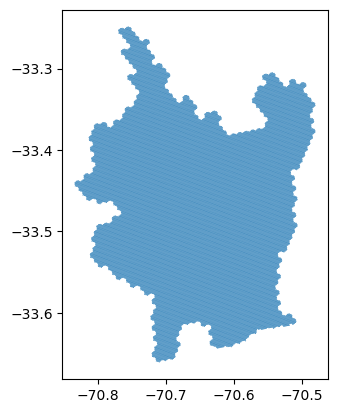

In [11]:
hex_gdf.plot()

## Process data - Create HQSL

HQSL definition

In [13]:
def calculate_hqsl(hex_gdf, hex_low_res, scale_max_value, parameters_dict):

    # ------------------------------------------------------------
    # --- NORMALIZE SOURCES (_scaledcount columns)
    for social_function in parameters_dict.keys():
        aup.log(f"--- {social_function}")
        for theme in parameters_dict[social_function]:
            aup.log(f"------ {theme}")
            for source in parameters_dict[social_function][theme]:

                # Set col name of interest and find min and max values
                if 'count' in source:
                    count_colname = source
                else:
                    count_colname = f"{source}_count_15min"

                # Prepare for MinMax Scalar
                hex_gdf[count_colname] = hex_gdf[count_colname] + 0.001
                min_val = np.log(0.001)
                max_val = np.log(hex_low_res[count_colname]).max()
                print(f"for col {count_colname} original max_val: {hex_gdf[count_colname].max()} and min_val: {hex_gdf[count_colname].min()}")
                print(f"for col {count_colname} log max_val: {max_val} and min_val: {min_val}")

                # Calculate MinMax Scalar
                # scale_max_value = 10
                hex_gdf[f"{source}_scaledcount"] = hex_gdf[count_colname].apply(lambda x: scale_max_value * ((np.log(x) - min_val) /(max_val - min_val)))
                hex_gdf.loc[hex_gdf[f"{source}_scaledcount"]>scale_max_value, f"{source}_scaledcount"] = scale_max_value
                aup.log(f"------ Scaled {source} count.")
                ''' # Drop original count col
                hex_gdf.drop(columns=[count_colname],inplace=True)
                # Add
                scalar_count_column_list.append(f"{source}_scaledcount")'''

    aup.log(f"--- Scaled count columns added to hex_gdf.")
    
    # Keep columns of interest only
    # proxhexs_countprocess = proxhexs_countprocess[['hex_id','geometry']+scalar_count_column_list+['res','city']]

    # ------------------------------------------------------------
    # --- SUM NORMALIZED SOURCES BY THEME AND BY SOCIAL FUNCTION
    aup.log(f"--- Starting social function analysis.")
    sum_count_column_list = []

    for social_function in parameters_dict.keys():
        # Set social function sources list
        sf_sources_list = []
        
        for theme in parameters_dict[social_function]:
            # Set theme_sources_list and feed sf_sources_list
            theme_sources_list = []
            for source in parameters_dict[social_function][theme]:
                theme_sources_list.append(f"{source}_scaledcount")
                sf_sources_list.append(f"{source}_scaledcount")
                
            # Find sum of count anlysis for theme
            hex_gdf[f"{theme}_count"] = hex_gdf[theme_sources_list].sum(axis=1)
            aup.log(f"------ Summed {theme} count with a mean value of " + str(round(hex_gdf[f"{theme}_count"].mean(),4)))
            sum_count_column_list.append(f"{theme}_count")
            
        # Find sum of count anlysis for social function
        hex_gdf[f"{social_function}_count"] = hex_gdf[sf_sources_list].sum(axis=1)
        aup.log(f"--- Summed {social_function} count with a mean value of {round(hex_gdf[f'{social_function}_count'].mean(),4)}.")
        sum_count_column_list.append(f"{social_function}_count")

    # ------------------------------------------------------------
    # --- NORMALIZE SOCIAL FUNCTION COLUMNS AND CREATE HQLS
    # Get social function count columns
    social_fn_cols = []
    for k in parameters_dict.keys():
        social_fn_cols.append(k+'_count')

    # Normalize social function columns before creating HQSL
    for sc in social_fn_cols:
        aup.log(f"--- Normalized social function {sc} from 0 to 30.")
        hex_gdf[sc] = 30 * (hex_gdf[sc] - hex_gdf[sc].min()) / (hex_gdf[sc].max() - hex_gdf[sc].min())
        hex_gdf.loc[hex_gdf.supermercado_time==0, sc] = hex_gdf.loc[hex_gdf.supermercado_time==0].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_gdf,
                                                                            sc), axis=1)

    # Create HQSL
    hex_gdf['hqsl'] = hex_gdf[social_fn_cols[0]] + hex_gdf[social_fn_cols[1]] + hex_gdf[social_fn_cols[2]] + hex_gdf[social_fn_cols[3]] + hex_gdf[social_fn_cols[4]] + hex_gdf[social_fn_cols[5]]
    aup.log(f"--- Calculated HQSL with a mean value of {round(hex_gdf['hqsl'].mean(),4)}.")
    
    return hex_gdf

Filter hexs with no nodes before running HQSL

In [14]:
hex_diss = hex_low_res.loc[hex_low_res.supermercado_time>0].dissolve()
hex_clip = gpd.clip(hex_gdf, hex_diss)
hex_id_list = list(hex_clip.hex_id.unique())
hex_gdf = hex_gdf.loc[hex_gdf.hex_id.isin(hex_id_list)].copy()

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(63727, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.0,6.049196,2.0,7.580963,2.0,50.542861,0.0,...,16.0,7.393075,4.0,10.0,Santiago,51.747597,1.186889,7.023599,0.0,0.135445


<Axes: >

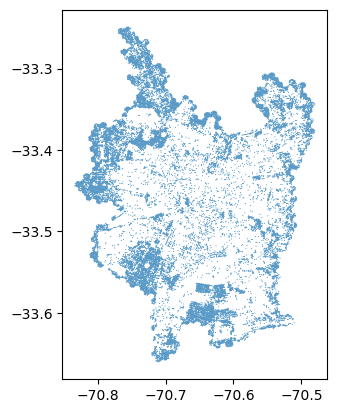

In [15]:
hex_gdf.loc[hex_gdf.supermercado_time==0].plot()

Calculate HQSL

In [16]:
hex_gdf = calculate_hqsl(hex_gdf, hex_low_res, 10, parameters_dict)

for col carniceria_count_15min original max_val: 11.001 and min_val: 0.001
for col carniceria_count_15min log max_val: 2.2079198664529676 and min_val: -6.907755278982137
for col hogar_count_15min original max_val: 28.001 and min_val: 0.001
for col hogar_count_15min log max_val: 3.0666840095262753 and min_val: -6.907755278982137
for col local_mini_market_count_15min original max_val: 100.001 and min_val: 0.001
for col local_mini_market_count_15min log max_val: 4.460121566456197 and min_val: -6.907755278982137
for col bakeries_count_15min original max_val: 52.001 and min_val: 0.001
for col bakeries_count_15min log max_val: 3.780748201004849 and min_val: -6.907755278982137
for col ferias_count_15min original max_val: 9.001 and min_val: 0.001
for col ferias_count_15min log max_val: 1.997425372002954 and min_val: -6.907755278982137
for col supermercado_count_15min original max_val: 15.917666666666666 and min_val: 0.001
for col supermercado_count_15min log max_val: 2.5641720546629747 and min

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col museos_pub_count_15min original max_val: 9.001 and min_val: 0.001
for col museos_pub_count_15min log max_val: 1.9818030721159199 and min_val: -6.907755278982137
for col bibliotecas_count_15min original max_val: 2.001 and min_val: 0.001
for col bibliotecas_count_15min log max_val: 0.6931471805599453 and min_val: -6.907755278982137
for col sitios_historicos_count_15min original max_val: 66.501 and min_val: 0.001
for col sitios_historicos_count_15min log max_val: 3.983847174624248 and min_val: -6.907755278982137
for col ndvi_count original max_val: 0.6981733927726745 and min_val: -0.31825637742135093
for col ndvi_count log max_val: -0.7539983600866187 and min_val: -6.907755278982137
for col cines_count_15min original max_val: 11.001 and min_val: 0.001
for col cines_count_15min log max_val: 2.193341077309822 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col librerias_count_15min original max_val: 24.001 and min_val: 0.001
for col librerias_count_15min log max_val: 3.0029734348105506 and min_val: -6.907755278982137
for col restaurantes_bar_cafe_count_15min original max_val: 189.201 and min_val: 0.001
for col restaurantes_bar_cafe_count_15min log max_val: 5.057956282434942 and min_val: -6.907755278982137
for col jardin_inf_pub_count_15min original max_val: 14.08795652173913 and min_val: 0.001
for col jardin_inf_pub_count_15min log max_val: 2.4530592980919956 and min_val: -6.907755278982137
for col jardin_inf_priv_count_15min original max_val: 9.001 and min_val: 0.001
for col jardin_inf_priv_count_15min log max_val: 1.9350992329510976 and min_val: -6.907755278982137
for col edu_especial_pub_count_15min original max_val: 15.001 and min_val: 0.001
for col edu_especial_pub_count_15min log max_val: 2.3951532913710647 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col edu_especial_priv_count_15min original max_val: 1.001 and min_val: 0.001
for col edu_especial_priv_count_15min log max_val: 0.0 and min_val: -6.907755278982137
for col edu_basica_pub_count_15min original max_val: 22.501 and min_val: 0.001
for col edu_basica_pub_count_15min log max_val: 2.8735646395797834 and min_val: -6.907755278982137
for col edu_basica_priv_count_15min original max_val: 14.22322222222222 and min_val: 0.001
for col edu_basica_priv_count_15min log max_val: 2.2366448116394047 and min_val: -6.907755278982137
for col edu_media_pub_count_15min original max_val: 17.001 and min_val: 0.001
for col edu_media_pub_count_15min log max_val: 2.6224923127405635 and min_val: -6.907755278982137
for col edu_media_priv_count_15min original max_val: 13.22322222222222 and min_val: 0.001
for col edu_media_priv_count_15min log max_val: 2.1370862185976858 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col edu_tecnica_count_15min original max_val: 17.001 and min_val: 0.001
for col edu_tecnica_count_15min log max_val: 2.5954330819610547 and min_val: -6.907755278982137
for col universidad_count_15min original max_val: 101.001 and min_val: 0.001
for col universidad_count_15min log max_val: 4.360430567455984 and min_val: -6.907755278982137
for col edu_adultos_pub_count_15min original max_val: 6.112111111111111 and min_val: 0.001
for col edu_adultos_pub_count_15min log max_val: 1.594991433260704 and min_val: -6.907755278982137
for col edu_adultos_priv_count_15min original max_val: 3.001 and min_val: 0.001
for col edu_adultos_priv_count_15min log max_val: 0.709346911774054 and min_val: -6.907755278982137
for col centro_edu_amb_count_15min original max_val: 1.001 and min_val: 0.001
for col centro_edu_amb_count_15min log max_val: 0.0 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col oficinas_count original max_val: 124.20947757482655 and min_val: 0.001
for col oficinas_count log max_val: 3.247319182424446 and min_val: -6.907755278982137
for col ciclovias_count_15min original max_val: 26.001 and min_val: 0.001
for col ciclovias_count_15min log max_val: 3.0842904052843805 and min_val: -6.907755278982137
for col paradas_tp_count_15min original max_val: 117.001 and min_val: 0.001
for col paradas_tp_count_15min log max_val: 4.665041210738592 and min_val: -6.907755278982137
for col paradas_tp_tren_count_15min original max_val: 2.001 and min_val: 0.001
for col paradas_tp_tren_count_15min log max_val: 0.5996211225491218 and min_val: -6.907755278982137
for col paradas_tp_metro_count_15min original max_val: 7.001 and min_val: 0.001
for col paradas_tp_metro_count_15min log max_val: 1.6757179441498946 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

### Results review

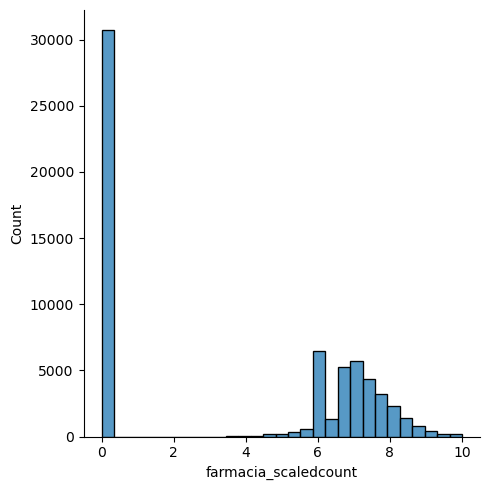

In [17]:
sns.displot(hex_gdf, x="farmacia_scaledcount")

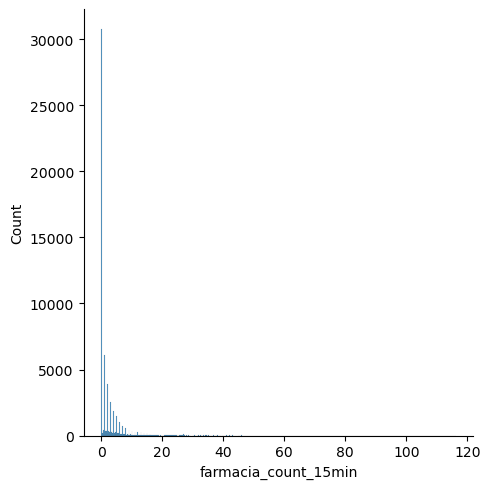

In [18]:
sns.displot(hex_gdf, x="farmacia_count_15min")

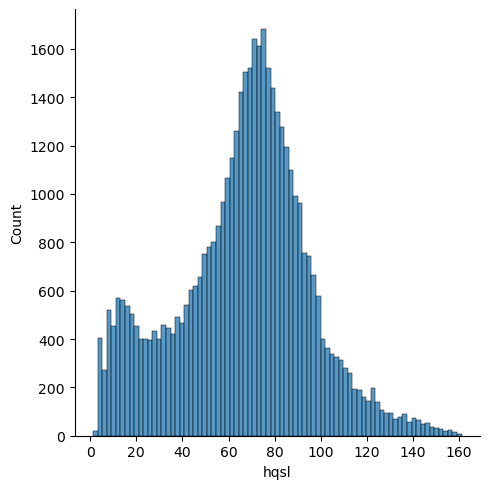

In [19]:
sns.displot(hex_gdf.loc[hex_gdf.supermercado_time>0],
            x=hex_gdf.loc[hex_gdf.supermercado_time>0,"hqsl"])

<Axes: >

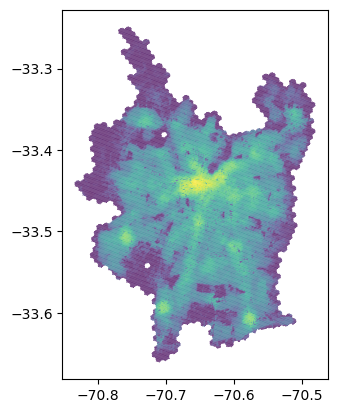

In [20]:
hex_gdf.plot('hqsl')

### Upload data

In [22]:
if save:
    processed_table_name = 'santiago_hexproximity_hqsl_4_5_kmh'
    aup.gdf_to_db_slow(hex_gdf, processed_table_name, 'projects_research', if_exists='replace')